In [1]:
##############################################################################
# Script used in the paper:
# Dune migration and volume change from airborne LiDAR, terrestrial LiDAR 
# and Structure from Motion--Multi View Stereo
# by
# Carlos H. Grohmann et al - 2019/2020
# guano (at) usp (dot) br
# Institute of Energy and Environment - University of Sao Paulo
#
# Please check the GitHub repo for the final reference to the paper
##############################################################################

#### Monte Carlo analysis of random points

To compare the elevation of elevation datasets, a few key points must be considered beforehand, such as spatial resolution, presence of voids and number of samples used in the analysis. A direct comparison of the raster datasets on a pixel-by-pixel basis, is not the best approach, since differences in pixel size and presence of voids could affect correlation analysis, and the large number of samples would impact descriptive statistics, goodness-of-fit and error measurements. 

A random sample of elevation values can overcome these issues, but raises the question of how many data points are needed to properly represent the original dataset. To answer this question, a Monte Carlo approach was devised in the following form:

- the model was run 50 times;
- the number of random points analyzed was n=50, 100, 250, 500, 1000, 2500, 5000 and 10000;
- in each run, *n* random points were created and elevation was extracted from SRTM;
- after 50 runs, correlation was calculated between the first and the 49 subsequent sets of *n* random points;
- a Four Parameter Logistic Regression (4PL) was calculated for the mean value of correlation of each set of *n* random points.

In order to ensure reproducibility of the analysis, the random seed used to generate points was set to the sequential number of each model run (0,1,2,3,...,49) multiplied by a constant. Results of this approach have shown that for the TLS aurvey area, 1000 random points can be used to describe the elevation of the dataset.

In [2]:
# 1 - Extract elevation for sets of randon points [50,100,250,500,1000,2000,5000,10000] and then
# calculate stats for each. 

# MonteCarlo-like analysis:
# 0 - for a series of n random points [50,100,250,500,1000,2000,5000,10000]:
# 1 - get X sets of n random points (rand_n_01, rand_n_02, rand_n_03,...) - sorted
# 2 - calculate correlation between first set and all others
# 3 - put data in a table and plot the results
# 4 - make plot off all values (X = n_points, Y = correlation)

In [3]:
# import python libraries
import sys, os, itertools
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import subprocess
from IPython.display import Image # can use this to display GRASS maps
# stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import linregress
from scipy.optimize import leastsq

In [4]:
# helper func: delete all *random maps
def clean_rand():
    grass.run_command('g.remove', type='vector', pattern='*random*', flags='f')

In [5]:
# helper func: round to nearest 5
def round5(x):
    rounded = int(round(x/5.0)*5.0)
    return rounded

In [6]:
# aux func: sample DEMs elevations
# requires dbsae connection in GRASS to be SQLITE
def sample_dems_mc(dem, n_points, mc_run, ow_vector, ow_what, vmask):
    ''' create random points for selected tile and sample the elevation values 
    simplified version of sample_dems tailored for MonteCarlo-like analysis
    dem = raster map (elevation)
    n_points = number of random points
    mc_run = number of times a set of random pints will be created 
    ow_vector = should vector maps be overwritten?
    ow_what = re-run v.what.rast ? 
    vmask = vector mask to restrict points

    note: to keep random points really randon and yet ensure reproducibility,
    random seed is set to the value of mc_run * 42'''
    
    grass.run_command('g.region', raster=dem, flags='a')
    
    # random points 
    vector_name = dem.split('_')[0] +'_random_' + str(n_points) + '_' + str(mc_run).zfill(2)
    grass.run_command('v.random', output=vector_name, npoints=n_points, restrict=vmask, seed=mc_run*42, quiet=True, overwrite=ow_vector) 
    rand_col = 'rand_' + str(n_points) + '_' + str(mc_run)
    grass.run_command('v.db.addtable', map=vector_name, columns=rand_col+' double precision', quiet=True, overwrite=ow_vector)
        
    # sample raster map - force if overwrite vector is true
    if ow_vector or ow_what:
        grass.run_command('v.what.rast', map=vector_name, raster=dem, column=rand_col, quiet=True)
        
    # export as ascii and read into python
    xyz = grass.read_command('v.out.ascii', input=vector_name, type='point', format='point', columns=rand_col, overwrite=True)
    elev_list = [float(attr.split('|')[3]) if attr.split('|')[3] != '' else None for attr in xyz.split('\n')[:-1]]
    elev = np.asarray(elev_list, dtype=np.float64)
    
    return elev

In [7]:
# aux func: fits a 4PL curve to mean of correlation values
# plots and funcs from http://people.duke.edu/~ccc14/pcfb/analysis.html
def logistic4(x, A, B, C, D):
    ''' 4PL logistic equation ''' 
    return ((A-D)/(1.0+((x/C)**B))) + D

def residuals(p, y, x):
    ''' Deviations of data from fitted 4PL curve ''' 
    A,B,C,D = p
    err = y-logistic4(x, A, B, C, D)
    return err

def peval(x, p):
    ''' Evaluated value at x with current parameters ''' 
    A,B,C,D = p
    return logistic4(x, A, B, C, D)

In [8]:
# matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline

In [9]:
# create GRASS GIS runtime environment
# with this, you can run GRASS without startig a shell/gui session
gisbase = subprocess.check_output(["grass76", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# GRASS GIS imports
import grass.script as grass
import grass.script.setup as gsetup
import grass.script.array as garray
import grass.script.vector as gvect

In [10]:
# set GRASS GIS session data
# I use two systems, so this makes things a bit easier
if sys.platform == "linux" or sys.platform == "linux2":
    rcfile = gsetup.init(gisbase, "/mnt/sda/grassdata/", "utm", "garopaba_22J")
elif sys.platform == "darwin":
    rcfile = gsetup.init(gisbase, "/Volumes/MacintoshHD2/grassdata/", "utm", "garopaba_22J")
# elif platform == "win32":
    # Windows...
    
# grass.message('Current GRASS GIS 7 environment:')
# print grass.gisenv()

In [11]:
# overwrite for GRASS modules
ow = True

In [12]:
# Data dir 
# use this to set different paths for different systems
if sys.platform == "linux" or sys.platform == "linux2":
    dataDir = '/mnt/sda/Dropbox/USP/projetosPesquisa/LiDAR_terrestre_SfM/_areas_estudo/garopaba/monteCarlo/'
elif sys.platform == "darwin":
    dataDir = '/Volumes/MacintoshHD2/Dropbox/USP/projetosPesquisa/LiDAR_terrestre_SfM/_areas_estudo/garopaba/monteCarlo/'
#     dataDir = '_path_to_your_files_'
os.chdir(dataDir)
# os.getcwd()

In [13]:
# names for the files
method='bilinear'
step = 0.4
dem_tls_10cm = 'tls_rinxyz_mean_10cm_' + method + '_step_' + str(step)
dem_sfm_10cm = 'sfm_rinxyz_mean_10cm_' + method + '_step_' + str(step)
diff_sfm_tls_10cm = 'diff_10cm_sfm_tls'
mask_tls_sfm = 'mask_tls_sfm'

In [14]:
n_random = 50 # n runs 
npoints_list = [50,100,250,500,1000,2500,5000,10000]
dem_list = [dem_tls_10cm,dem_sfm_10cm]

In [15]:
# run monte carlo sampling and save data as csv
for dem,points in itertools.product(dem_list, npoints_list):
    df = pd.DataFrame()
    file_out = dem + '_rand_MC_' + str(points)
    for run in range(n_random):
        col_name = 'rand_' + str(points) + '_' + str(run).zfill(2)
        elev = sample_dems_mc(dem, points, mc_run=run, ow_vector=True, ow_what=True, vmask=mask_tls_sfm)
        df[col_name] = np.sort(elev)
        df.to_csv(path_or_buf=file_out+'.csv', na_rep='NaN')

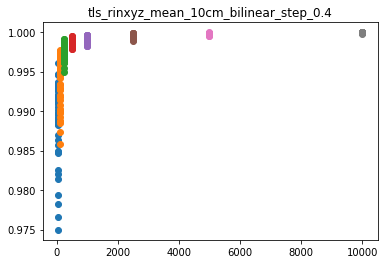

In [16]:
# reads data from csv files and calculates correlation
dem = dem_tls_10cm
avg_corr = []
df_corr = pd.DataFrame()
for points in npoints_list:
    csv_file = dem + '_rand_MC_' + str(points) + '.csv'
    #
    df = pd.read_csv(csv_file, index_col=0)
    # correlation of first column[0] with  all the others [1:]. 
    # No need to define column by name
    corr = df.corr().iloc[0,1:]
    avg_corr.append(corr.mean())
    #
    # plot correlation values for this set of random points
    x_ax = np.empty(n_random -1)
    x_ax.fill(points)
    plt.plot(x_ax, corr, 'o')
    plt.title(dem)

Text(0.5,1,u'tls_rinxyz_mean_10cm_bilinear_step_0.4')

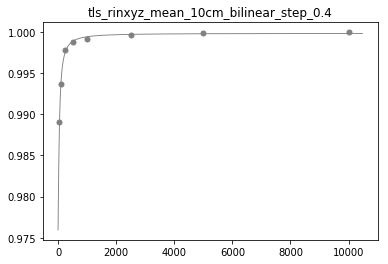

In [17]:
# curve fitting for mean of correlation values
# Initial guess for curve fitting parameters
p0 = [1, 1, 1, 1]
# observations
x = npoints_list
y_meas = avg_corr
# least-squares fitting
plsq = leastsq(residuals, p0, args=(y_meas, x)) 
equation = 'y = ((A-D)/(1.0+((x/C)**B))) + D' 
A = plsq[0][0]
B = plsq[0][1]
C = plsq[0][2]
D = plsq[0][3]

# sequence of values for curve plotting
xx=np.arange(0,10500,25)
# plot fitted curve
plt.plot(xx, peval(xx,plsq[0]), color='0.5', lw=0.9)
plt.plot(x, y_meas, 'o', color='0.5', ms=5)
plt.title(dem)

In [18]:
clean_rand()

In [19]:
# end GRASS GIS session
os.remove(rcfile)